## 深度学习求解非仿射Heston模型下的期权定价方程

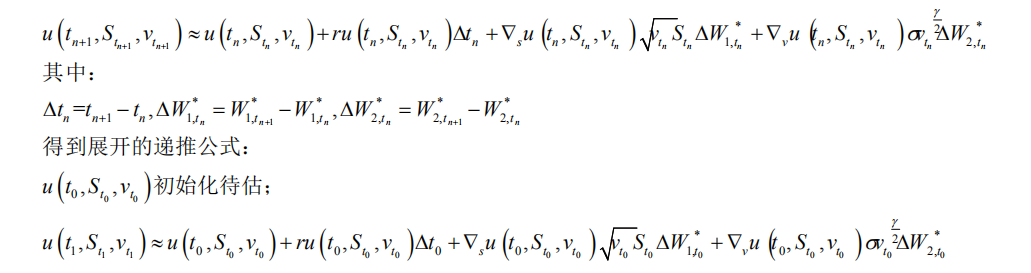

#### 开始是探索部分，后面两大cell是在tf1.x、tf2.x上代码
####  ‘# @@@@@@@@@@’ 是我修改的地方

#### 探索：生成的数据大概的shape下的递推函数

In [1]:
import numpy as np
# 4 条路径，0\1\2个时刻
#               s0,s1,s2   v0,v1,v2
X = np.array([[[1 ,2,3 ],[4 ,5 ,6 ]] # 路径1
             ,[[6 ,7 ,8 ],[9 ,10,11]] # 路径2
             ,[[12,13,14],[15,16,17]] # 路径3
             ,[[18,19,20],[21,22,23]]],dtype=float)  # 路径4
# X.shape = (batch,2,t)
#               dw10,dw11 dw21,dw22
dW = np.array([[[0.1,0.2],[0.4,0.5]]  # 路径1
              ,[[0.7,0.8],[1.0,1.1]]  # 路径2
              ,[[0.9,1.0],[1.1,1.2]]  # 路径3
              ,[[1.3,1.4],[1.5,1.6]]])# 路径4
# dW.shape = (batch,2,t)
#             tds0,tds1,tds2 tdv0,tdv1,tdv2
Z = np.array([[[1 ,2 ,3 ],   [4 ,5 ,6 ]]   # 路径1
             ,[[6 ,7 ,8 ],   [9 ,10,11]]   # 路径2
             ,[[12,13,14],   [15,16,17]]   # 路径3
             ,[[18,19,20],   [21,22,23]]]) # 路径4
# Z.shape = (batch,2,t)

# t = 1 时刻的Y
#          路径  1,    2,    3,   4
Y = np.array([[10.],[20.],[30.],[40.]])  # 前一时刻的u()值
# Y.shape(batch,1)

# 假设参数
r = 1
sigma = 2
gamma = 3
h = 1/240

# 为计算t=2时刻的Y,在t给定的条件下，x是二维的.
x = X[:,:,1]
dw = dW[:,:,0]
z = Z[:,:,1]

#### 计算递推公式
def f_tf(Y,Z,X,dW,r,sigma,gamma):
    return Y+r*Y*h+(Z[:,0]*np.sqrt(X[:,1])*X[:,0]*dW[:,0]+Z[:,1]*sigma*pow(X[:,1],gamma/2)*dW[:,1]).reshape(Y.shape)

# new Y = f_tf(),Y.ahape=(batch,1)
print(f_tf(Y,z,x,dw,r,sigma,gamma))


# tensor形式,值和上面一致,迭代函数
import tensorflow as tf
def f_tf(Y,Z,X,dW,r,sigma,gamma):
        f = tf.reshape((Z[:,0]*tf.sqrt(X[:,1])*X[:,0]*dW[:,0]+Z[:,1]*sigma*pow(X[:,1],gamma/2)*dW[:,1]),shape=(-1,1))
        return Y+r*Y*h+f
y = f_tf(Y,z,x,dw,r,sigma,gamma)
# 结果和np一致
with tf.Session():
    print(y.eval())

[[  55.65745341]
 [ 761.00498911]
 [2891.325     ]
 [9051.86246602]]
[[  55.65745341]
 [ 761.00498911]
 [2891.325     ]
 [9051.86246602]]


#### 损失函数   E[(Y-(ST-K))^2]

#### 路径生成

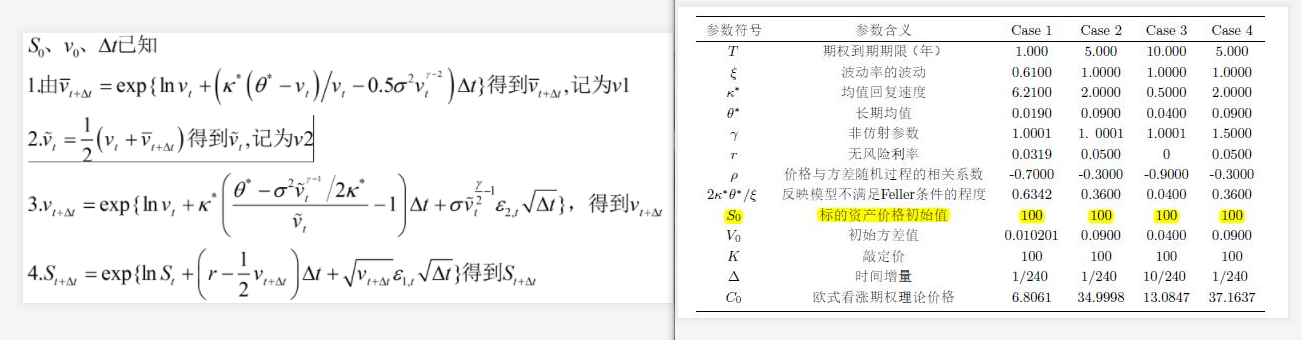

#### 1.生成一条路径

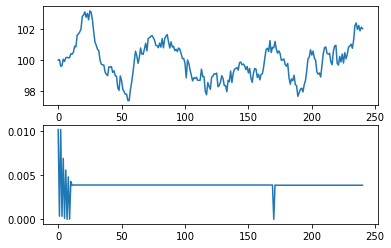

In [2]:
import numpy as np

# 参数第一组（case1）
T = 1.0
sigma = 0.61
kappa = 6.210
theta = 0.0190
gamma = 1.0001
r = 0.0319
lo = -0.700
S0 = 100
V0 = 0.010201
K = 100
h = 1/240         # delta t
n_time = int(T/h)

S = np.zeros(n_time+1);S[0]=S0
V = np.zeros(n_time+1);V[0]=V0
# 产生随机误差项
mean = [0,0];cov = [[1,lo],[lo,1]]
data = np.random.multivariate_normal(mean,cov,n_time)
e1 = data[:,0]
e2 = data[:,1]
for t in range(n_time):
    v1 = V[t]*np.exp((kappa*(theta-V[t])/V[t]-0.5*sigma**2*pow(V[t],gamma-2))*h)
    v2 = 1/2*(v1+V[t])
    V[t+1] = V[t]*np.exp(kappa*((theta-sigma**2*pow(v2,gamma-1)/2*kappa)/v2-1)*h+sigma*pow(v2,gamma/2-1)*e2[t]*np.sqrt(h))
    
    ################# 修正替换，发现在1e-5后会突变，均值替换 ##################
    if V[t+1] < 1e-5 or V[t+1] > 1e-1 :
        V[t+1] = np.mean(V[:t])
        
    S[t+1] = S[t]*np.exp((r-1/2*V[t+1])*h + np.sqrt(V[t+1])*e1[t]*np.sqrt(h))  
import matplotlib.pyplot as plt
plt.subplot(211)
plt.plot([*range(n_time+1)],S)
plt.subplot(212)
plt.plot([*range(n_time+1)],V)
plt.show()

#### 2.np生成多条路径

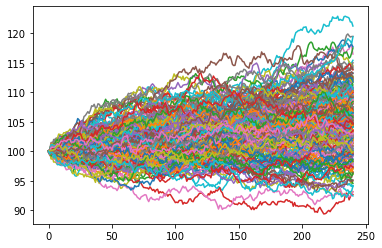

In [49]:
# 参数第一组(case1)
T = 1.0
sigma = 0.61
kappa = 6.210
theta = 0.019
gamma = 1.0001
r = 0.0319
lo = -0.700
S0 = 100
V0 = 0.010201
K = 100
h = 1/240         # delta t
n_time = int(T/h)
d = 2
n_sample = 200

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as normal

def sample(n_sample):
    X = np.zeros([n_sample,d,n_time+1])
    # 多条路径
    for i in range(n_sample):
        # 一条路径的生成
        S = np.zeros(n_time+1);S[0]=S0
        V = np.zeros(n_time+1);V[0]=V0
        mean = [0,0];cov = [[1,lo],[lo,1]]
        data = np.random.multivariate_normal(mean,cov,n_time)
        e1 = data[:,0]
        e2 = data[:,1]
        for t in range(n_time):
            v1 = V[t]*np.exp((kappa*(theta-V[t])/V[t]-0.5*sigma**2*pow(V[t],gamma-2))*h)
            v2 = 1/2*(v1+V[t])
            V[t+1] = V[t]*np.exp(kappa*((theta-sigma**2*pow(v2,gamma-1)/2*kappa)/v2-1)*h+sigma*pow(v2,gamma/2-1)*e2[t]*np.sqrt(h))
            
            ################# 修正替换，发现在1e-5后会突变，均值替换 ##################
            if V[t+1] < 1e-6 or V[t+1] > 1e-1 :
                V[t+1] = np.mean(V[:t+1])
                
            S[t+1] = S[t]*np.exp((r-1/2*V[t+1])*h + np.sqrt(V[t+1])*e1[t]*np.sqrt(h))
        X[i,0] = S
        X[i,1] = V
    return X
    
x = sample(n_sample)
for i in range(n_sample):
    plt.plot([*range(n_time+1)],x[i,0])   #x[i,0]是st,x[i,1]是vt

#### 3.在类、tensorflow形式下书写sample_path

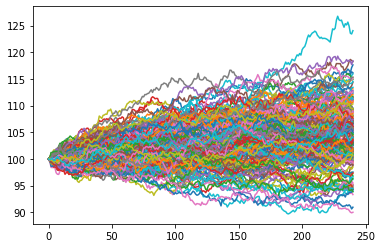

In [3]:
import math
import numpy as np
from scipy.stats import multivariate_normal as normal 
class SolveAllenCahn (object):
    def __init__ (self):
        # parameters 
        self.d = 2      # 数据的维度
        self.T = 1.0      # 每一条路径的时间长度
        # parameters for the algorithm
        self.h = 1/240    # 每一个路径中数据时间间隔，delta t = 1/32
        self.n_time = int(self.T/self.h)     # 有20个t
        self.n_layer = 4     # 神经网络的层数
        self.n_neuron = [self.d ,self.d +10 ,self.d +10, self.d ]    # 各层神经元的个数，对应输入、隐藏层1、隐藏层2、输出
        self.batch_size = 64      # 一次用到个路径计算，64*4=256
        self.valid_size = 256     # 256个蒙特卡洛样本（路径）
        self.n_maxstep = 4000     # 迭代步数
        self.n_displaystep = 100     # 每100步print一次
        self.learning_rate = 5e-4    # 学习率
        self.Yini = [0,10]       # 初始值Y0的最大最小值
        # some basic constants and variables

        self.sqrth = math.sqrt(self.h)    # 根号delta t，后面用于计算
        self.t_stamp = np.arange(0,self.n_time)*self.h  # 时间戳，累计的时间
        self._extra_train_ops = []  # batch移动平均值操作，其中需要额外训练的beta和gamma
        
        # 参数第1组(case1)
        self.sigma = 0.61
        self.kappa = 6.21
        self.theta = 0.019
        self.gamma = 1.0001
        self.r = 0.0319
        self.lo = -0.700
        self.S0 = 100
        self.V0 = 0.010201
        self.K = 100

    def sample_path(self, n_sample):
        dW = np.zeros([n_sample,self.d,self.n_time])
        X = np.zeros([n_sample,self.d,self.n_time+1])
        # 多条路径
        for i in range(n_sample):
            # 一条路径的生成
            S = np.zeros(self.n_time+1);S[0]=self.S0
            V = np.zeros(self.n_time+1);V[0]=self.V0
            mean = [0,0]; cov = [[1,self.lo],[self.lo,1]]
            data = np.random.multivariate_normal(mean,cov,self.n_time)
            e1 = data[:,0]; e2 = data[:,1]
            for t in range(self.n_time):
                v1 = V[t]*np.exp((self.kappa*(self.theta-V[t])/V[t]-0.5*self.sigma**2*pow(V[t],self.gamma-2))*self.h)
                v2 = 1/2*(v1+V[t])
                V[t+1] = V[t]*np.exp(self.kappa*((self.theta-self.sigma**2*pow(v2,self.gamma-1)/2*self.kappa)/v2-1)*self.h+ \
                                     self.sigma*pow(v2,self.gamma/2-1)*e2[t]*self.sqrth)
                
                ################# 修正替换，发现在1e-5后会突变，均值替换 ##################
                if V[t+1] < 1e-6 or V[t+1] > 1e-1 :
                    V[t+1] = np.mean(V[:t+1])
                    
                S[t+1] = S[t]*np.exp((self.r-1/2*V[t+1])*self.h+np.sqrt(V[t+1])*e1[t]*self.sqrth)
            X[i,0] = S
            X[i,1] = V
        for i in range(self.n_time):    # 一次生成一列
            dW[:,:,i] = \
               np.reshape(normal.rvs(mean = np.zeros(self.d) ,  # 该函数相当于np.random.normal()
                                     cov=1,   
                                     size = n_sample)* self.sqrth ,   # 根号delta t，W(t)-W(s)独立于的W(r),且是期望为0方差为t-s
                          (n_sample,self.d))
        return dW,X
            
model = SolveAllenCahn()
dw,x=model.sample_path(1000)

import matplotlib.pyplot as plt
for i in range(200):
    plt.plot([*range(241)],x[i,0])

### 最终code

#### 1.tensorflow1.14.0

In [4]:
'''
损失函数是loss=E（|ST-K-u（T)|2）
'''
import time  
import math
import tensorflow as tf
import numpy as np
from tensorflow.python.training.moving_averages import assign_moving_average   # 移动平均
from scipy.stats import multivariate_normal as normal            # 产生正态分布随机数
from tensorflow.python.ops import control_flow_ops               #用于控制流  
from tensorflow import random_normal_initializer as norm_init    #生成具有正态分布的张量的初始化器
from tensorflow import random_uniform_initializer as unif_init   #生成具有均匀分布的张量的初始化器
from tensorflow import constant_initializer as const_init        #生成具有常量值的张量的初始化器


class SolveAllenCahn (object):
    """ The fully-connected neural network model """  
    def __init__ (self,sess):
        self.sess = sess   # 会话
        self.d = 2  # 数据的维度[sT,vT]          # @@@@@@@@@@
        self.T = 1.0    # 每一条路径的时间长度            # @@@@@@@@@@
        self.h = 1/240    # 每一个路径中数据时间间隔，delta t    # @@@@@@@@@@
        self.n_time = int(self.T/self.h)    # time_steps
        self.sqrth = math.sqrt(self.h)    # 根号delta t，后面用于计算
        self.t_stamp = np.arange(0,self.n_time)*self.h  # 时间戳，向前累计的时间
        self.n_layer = 4    # 神经网络的层数
        self.n_neuron = [self.d ,self.d +10 ,self.d +10, self.d]  # 各层神经元的个数，对应输入、隐藏层1、隐藏层2、输出层
        self.batch_size = 64    # 一次迭代运算的路径数
        self.valid_size = 256    # 256个验证路径
        self.n_maxstep = 10000     # 迭代步数
        self.n_displaystep = 100     # 每100步打印一下信息
        self.learning_rate = 5e-2    # 学习率
        self.Yini = [0,10]       # 初始值Y0的最大最小值     # @@@@@@@@@@
        # some basic constants and variables
        self._extra_train_ops = []  # batch移动平均值操作，其中需要额外训练的beta和gamma
        
        # Henston model etr 参数1
        self.sigma = 0.61       # @@@@@@@@@@
        self.kappa = 6.2100     # @@@@@@@@@@
        self.theta = 0.019       # @@@@@@@@@@
        self.gamma = 1.0001     # @@@@@@@@@@
        self.r = 0.0319         # @@@@@@@@@@
        self.lo = -0.700        # @@@@@@@@@@
        self.S0 = 100           # @@@@@@@@@@
        self.V0 = 0.010201      # @@@@@@@@@@
        self.K = 100            # @@@@@@@@@@
        # c0 = 6.8061
        
    def train(self):
        # 主要函数，用于神经网络的训练
        start_time = time.time()   # 起始时间
        self.global_step = \
            tf.get_variable('global_step', [] ,
                              initializer = tf.constant_initializer(1),
                              trainable = False,dtype = tf.int32 )   # 没有添加到要训练的变量列表，计步器
        trainable_vars = tf.trainable_variables()  # 查看可训练的变量
        grads = tf.gradients(self.loss,trainable_vars)  # loss可训练变量的梯度
        optimizer = tf.train.AdamOptimizer(self.learning_rate)    # 梯度优化器
        apply_op = \
            optimizer.apply_gradients(zip(grads,trainable_vars) ,    # 将梯度用来更新trainable_vars列表中的东西
                                          global_step = self.global_step)   # 更新梯度和迭代次数
        
        train_ops = [apply_op] + self._extra_train_ops   # 添加操作，相当于list1.extand(list2)
        self.train_op = tf.group(* train_ops)   # tf.group(*train_ops)组合*train_ops的操作
        
        self.loss_history = []   # 用于记录loss值
        self.init_history = []   # 用于记录Y0的值
        
        # for validation,256条蒙特卡洛做验证集
        dW_valid , X_valid = self.sample_path(self.valid_size)   # 生成数据
        feed_dict_valid = { self.dW : dW_valid,   # 喂数据给buildmodel中的占位符
                            self.X : X_valid,
                            self.is_training: False }   # 不列入迭代范围
        # initialization
        step = 1
        self.sess.run (tf.global_variables_initializer())  # 初始化全局变量
        
        # 运行框架
        temp_loss = self.sess.run(self.loss ,
                                  feed_dict = feed_dict_valid )  # 计算损失
        
        temp_init = self.Y0.eval()[0] # # 取出值，Y0是二维张量
        self.loss_history.append(temp_loss)  # 记录loss
        self.init_history.append(temp_init)  # 记录Y0
        print("step : %5u , loss : %.4e , " % \
                (0 ,temp_loss ) + \
                "Y0 : % .4e , runtime : %4u " % \
                (temp_init, time.time()-start_time + self.t_bd))   # 打印step=0的状态
        
        # begin sgd iteration，0-4000步
        for _ in range (self.n_maxstep +1):   
            step = self.sess.run (self.global_step)
            dW_train,X_train = self.sample_path(self.batch_size)  # 生成数据
            self.sess.run(self.train_op,
                          feed_dict ={self.dW : dW_train ,   # 喂数据给buildmodel中的占位符
                                      self.X : X_train ,
                                      self.is_training : True })
            if step % self.n_displaystep == 0:   # 每100步用验证集测试一下损失和Y0的值
                temp_loss = self.sess.run(self.loss ,
                                          feed_dict = feed_dict_valid)
                temp_init = self.Y0.eval()[0]    # 取出值
                self.loss_history.append(temp_loss)    # 损失值
                self.init_history.append(temp_init )   # Y0值，Y0是二维张量
                print("step : % 5u , loss : %.4e , " % \
                        ( step , temp_loss ) + \
                        " Y0 : % .4e , runtime : %4u " % \
                        (temp_init , time.time() - start_time + self.t_bd ))
            step += 1
        end_time = time.time()  # 训练结束的总时间
        print(" running time : % .3f s " % \
                ( end_time - start_time + self.t_bd ))

    def build(self):
        # build the whole network by stacking subnetworks，构架大网络
        start_time = time.time () 
        # dW、X、is_training的占位符，为什么是None,因为一次计算一个batch
        self.dW = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time ] ,name = 'dW')   # None*100*20
        self.X = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time +1] ,name = 'X')   # None*100*20
        self.is_training = tf.placeholder (tf.bool)
        
        # 初始化Y0\Z0
        self.Y0 = tf.Variable(tf.random_uniform([1],                      # u0初始化,一个维度一个值  
                                                minval = self.Yini [0] ,   # 最小值 
                                                maxval = self.Yini [1] ,   # 最大值
                                                dtype = tf.float64 ));
        self.Z0 = tf.Variable (tf.random_uniform ([1,self.d] ,    # u梯度的初始值，一个1*d 向量
                                                minval = -.1 ,   # 最小值
                                                maxval =.1 ,    # 最大值
                                                dtype = tf.float64 ))
        self.allones = \
             tf.ones(shape = tf.stack([ tf.shape(self.dW)[0],1]) ,   # tf.shape(self.dW)[0]=len(batch),shape=(batch,1)
                         dtype = tf.float64 )                        # 作用，批量（batch）产生初始值

        Y = self.allones * self.Y0  # 初始的Y作为输入,每一个batch都赋予相同的初始Y值，Y是一个(batch,1)二维矩阵[[],[],..,]
        Z = tf.matmul(self.allones, self.Z0 )  # 初始的Z做为输入，作用和Y相同，但是由于Z是一个向量所以要乘积（batch,d）矩阵
        
        
        with tf.variable_scope('forward'):   # 前向
            for t in range(self.n_time -1):  # 前N-1个xt的网络
                    Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])  # 递推公式      # @@@@@@@@@@
                    Z = self._one_time_net(self.X[:,:,t+1] ,  # 得到“u梯度”-- 由神经网络训练而来的。
                                       str(t +1))/self.d      # str(t +1) 名字，why /self.d ?
            # terminal time，因为最后一刻的Y不用神经网络了
            Y = self.f_tf(self.t_stamp[self.n_time -1] ,        # @@@@@@@@@@
                                  Y,Z,self.X[:,:,self.n_time -1] , 
                                  self.dW[:,:,self.n_time -1])   
            term_delta = Y - self.g_tf(self.T,self.X[:,:,self.n_time]) # 损失函数公式   # @@@@@@@@@@
            self.clipped_delta = \
                  tf.clip_by_value(term_delta ,-50.0 , 50.0)  #将一个张量中的数值限制在一个范围之内，大于为上界，小于为下界
            self.loss = tf.reduce_mean(self.clipped_delta**2)  #计算损失，来源于损失函数
        self.t_bd = time.time() - start_time  # 生成网络的时间

    def sample_path(self, n_sample):
        '''重点重写'''                     # @@@@@@@@@@
        dW = np.zeros([n_sample,self.d,self.n_time])
        X = np.zeros([n_sample,self.d,self.n_time+1])
        # 多条路径
        for i in range(n_sample):
            # 一条路径的生成
            S = np.zeros(self.n_time+1);S[0]=self.S0
            V = np.zeros(self.n_time+1);V[0]=self.V0
            mean = [0,0]; cov = [[1,self.lo],[self.lo,1]]
            data = np.random.multivariate_normal(mean,cov,self.n_time)
            e1 = data[:,0]; e2 = data[:,1]
            for t in range(self.n_time):
                v1 = V[t]*np.exp((self.kappa*(self.theta-V[t])/V[t]-0.5*self.sigma**2*pow(V[t],self.gamma-2))*self.h)
                v2 = 1/2*(v1+V[t])
                V[t+1] = V[t]*np.exp(self.kappa*((self.theta-self.sigma**2*pow(v2,self.gamma-1)/2*self.kappa)/v2-1)*self.h+ \
                                     self.sigma*pow(v2,self.gamma/2-1)*e2[t]*self.sqrth)
                
                ################# 修正替换，发现在1e-5后会突变，均值替换 ##################
                if V[t+1] < 1e-6 or V[t+1] > 1e-1 :
                    V[t+1] = np.mean(V[:t+1])
                    
                S[t+1] = S[t]*np.exp((self.r-1/2*V[t+1])*self.h+np.sqrt(V[t+1])*e1[t]*self.sqrth)
            X[i,0] = S
            X[i,1] = V
        for i in range(self.n_time):    # 一次生成一列
            dW[:,:,i] = \
               np.reshape(normal.rvs(mean = np.zeros(self.d) ,  # 该函数相当于np.random.normal()
                                     cov=1,   
                                     size = n_sample)* self.sqrth ,   # 根号delta t，W(t)-W(s)独立于的W(r),且是期望为0方差为t-s
                          (n_sample,self.d))
        return dW,X
    
    def g_tf(self,t,X):                                               # @@@@@@@@@@
        # terminal conditions
        return X[:,0]-self.K   # X[:,0]是T时刻的ST值，重写了g(x)     # @@@@@@@@@@

    def f_tf(self,t,Y,Z,X,dW):   # @@@@@@@@@@重写了递推公式                   
        f = tf.reshape((Z[:,0]*tf.sqrt(X[:,1])*X[:,0]*dW[:,0]+Z[:,1]*self.sigma*pow(X[:,1],self.gamma/2)*dW[:,1]),shape=(-1,1))# @@@@@@@
        return Y+self.r*Y*self.h+f

    def _one_time_net(self , x ,name ):
        # x.shape = (batch,2)，得到z.shape=(batch,2)。输入的数据含有t,当t确定x就是二维的
        # 一个batch在t时刻的网络构架，输出梯度,不用
        with tf.variable_scope(name):
            x_norm = self._batch_norm(x , name = 'layer0_normal')  # 对batch标准化，作为输入
            layer1 = self._one_layer(x_norm , self.n_neuron [1] ,   # 隐藏层1输入输出input(batch,d),output(batch，d+10)
                                      name = 'layer1')
            layer2 = self._one_layer(layer1,self.n_neuron[2] ,  # 隐藏层2 input(batch,d+10),output(batch,d+10)
                                      name = 'layer2')
            z = self._one_layer(layer2 , self.n_neuron [3] , #  输出层，不加relu函数做激活input(batch,d+10),output(baatch,d)
                                     activation_fn = None , name = 'final')
        return z

    def _one_layer(self , input_ , out_sz ,
                   activation_fn = tf.nn.relu ,
                   std =5.0 , name = 'linear'):
        # 输入input_=（batch,d）,输出(batch,out_sz)
        # 一个层里面的计算操作,一个层的输入，返回一个层的输出0，被_one_time_net调用用于构造一个时刻的神经网络
        with tf.variable_scope(name):
            shape = input_.get_shape().as_list()  # list(输入的维度)
            w = tf.get_variable('Matrix',     # get_variable它一定是和tf.variable_scope()共同使用的
                                [shape[1], out_sz] ,tf.float64,    # 输入维度和输出维度
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1]+ out_sz )))  # 生成权重矩阵
            hidden = tf.matmul(input_ ,w )  # 矩阵乘积，隐藏计算中间结果
            hidden_bn = self._batch_norm(hidden, name = 'normal')  # batch标准化
            
        if activation_fn != None :
            return activation_fn(hidden_bn)  # 激活函数
        else :
            return hidden_bn  #不加激活函数,线性,最后一层网络

    def _batch_norm(self , x , name ):
        # 输入的和输出的shape相同
        """ Batch normalization """ # beta、gamma需要训练，第三类参数来源,一次标准化需要2列参数
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[ -1]]   # [d,d+10,d+10,d]，第一个维度是batch
            beta = tf.get_variable('beta', params_shape ,
                                         tf.float64 ,
                                         norm_init(0.0 , stddev =0.1 ,  # 正态分布随机数
                                         dtype = tf.float64 ))
            gamma = tf.get_variable( 'gamma', params_shape ,
                                         tf.float64 ,
                                         unif_init (0.1,0.5 ,   # 均匀分布随机数
                                         dtype = tf.float64 ))
            mv_mean = tf.get_variable('moving_mean' ,   # 由于每次的batch不同，所以用moving_mean来改进mean
                                         params_shape ,
                                         tf.float64 ,
                                         const_init (0.0 ,tf.float64 ) ,  # 初始化为0
                                         trainable = False )
            mv_var = tf.get_variable('moving_variance' ,
                                        params_shape ,
                                        tf.float64 ,
                                        const_init(1.0 , tf.float64 ) ,  # 初始化为1
                                        trainable = False )
            
            # These ops will only be preformed when training
            mean ,variance = tf.nn.moments(x ,[0] , name = 'moments')#需要标准化的中心维度,[0]表示batch,求64个数据的均值方差
            self._extra_train_ops.append (\
                 assign_moving_average(mv_mean , mean , 0.99))  # 下面详解
            self._extra_train_ops.append (\
                 assign_moving_average(mv_var , variance , 0.99))
            
            mean,variance = \
                control_flow_ops.cond(self.is_training ,            # control_flow_ops.cond控制执行流，第一个为条件
                                     lambda :( mean , variance ) , # 条件True时执行，train时，需要进行重新求均值方差
                                     lambda :( mv_mean , mv_var )) # 条件False时执行,test时，直接调用最后一次的平滑值
            
            y = tf.nn.batch_normalization (x , mean , variance ,
                                           beta , gamma , 1e-6)   
            # 上面一步的操作相当于:  
            # y = (y - mean)/tf.sqrt(variance+1e-6)  # 1e-6 epslion
            # y = y * gamma + beta
            # 确保标准化后的形状不变
            y.set_shape( x.get_shape())
            return y

def main ():
    # 运行框架
    tf.reset_default_graph ()
    with tf.Session() as sess :
        tf.set_random_seed (1)  # tf中的随机种子
        print(" Begin to solve Heston model 下期权定价 ")
        model = SolveAllenCahn (sess)  # 创建对象
        print('开始构建网络')
        model.build()   # 调用对象方法，构建了一个模型，即定义了各个解，但没有传入数据
        print('网络构建完成')
        model.train ()  # 生成并传数据到build
        output = np.zeros ((len(model.init_history), 3))   # 初始化结果为0,后面填充
        output[:,0] = np.arange(len( model.init_history ))* model.n_displaystep         # 输出step
        output[:,1] = model.loss_history  # 输出loss列表
        output[:,2] = model.init_history # 输出 Y0列表
#         np.savetxt("./ AllenCahn_d100.csv " ,  # 保存输出结果
#                      output ,
#                      fmt =[ '%d', '%.5e', '%.5e'] ,
#                      delimiter =",",
#                      header ="step ,loss function , " + \
#                      " target value , runtime " ,
#                      comments = '')

if __name__ == '__main__':
    np.random.seed(1) # 定义一个随机数种子
    main()  # 运行主程序

 Begin to solve Heston model 下期权定价 
开始构建网络
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
网络构建完成
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step :     0 , loss : 8.6038e+02 , Y0 :  1.6893e+00 , runtime :  403 
step :   100 , loss : 4.4456e+01 ,  Y0 :  1.7395e+00 , runtime :  646 
step :   200 , loss : 4.4156e+01 ,  Y0 :  1.7876e+00 , runtime :  723 
step :   300 , loss : 4.3838e+01 ,  Y0 :  1.8344e+00 , runtime :  800 
step :   400 , loss : 4.3584e+01 ,  Y0 :  1.8831e+00 , runtime :  876 
step :   500 , loss : 4.3237e+01 ,  Y0 :  1.9310e+00 , runtime :  953 
step :   600 , loss : 4.2949e+01 ,  Y0 :  1.9787e+00 , runtime : 1031 
step :

step :  9800 , loss : 3.6070e+01 ,  Y0 :  4.6274e+00 , runtime : 8176 
step :  9900 , loss : 3.6077e+01 ,  Y0 :  4.6408e+00 , runtime : 8256 
step :  10000 , loss : 3.6074e+01 ,  Y0 :  4.6368e+00 , runtime : 8337 
 running time :  8338.280 s 


#### 2.tensorflow 2.3.0

In [ ]:
import time  
import math
import tensorflow.compat.v1 as tf
import numpy as np
from tensorflow.python.training.moving_averages import assign_moving_average   # 移动平均
from scipy.stats import multivariate_normal as normal            # 产生正态分布随机数
from tensorflow.python.ops import control_flow_ops               #用于控制流  
from tensorflow import random_normal_initializer as norm_init    #生成具有正态分布的张量的初始化器
from tensorflow import random_uniform_initializer as unif_init   #生成具有均匀分布的张量的初始化器
from tensorflow import constant_initializer as const_init        #生成具有常量值的张量的初始化器

tf.disable_v2_behavior()   # 版本兼容

class SolveAllenCahn (object):
    """ The fully-connected neural network model ."""  
    def __init__ (self,sess):
        self.sess = sess   # 会话
        self.d = 2  # 数据的维度[sT,vT]          # @@@@@@@@@@
        self.T = 1.0    # 每一条路径的时间长度            # @@@@@@@@@@
        self.h = 1/240    # 每一个路径中数据时间间隔，delta t    # @@@@@@@@@@
        self.n_time = int(self.T/self.h)    # time_steps
        self.sqrth = math.sqrt(self.h)    # 根号delta t，后面用于计算
        self.t_stamp = np.arange(0,self.n_time)*self.h  # 时间戳，向前累计的时间
        self.n_layer = 4    # 神经网络的层数
        self.n_neuron = [self.d ,self.d +10 ,self.d +10, self.d]  # 各层神经元的个数，对应输入、隐藏层1、隐藏层2、输出层
        self.batch_size = 64    # 一次迭代运算的路径数
        self.valid_size = 256    # 256个验证路径
        self.n_maxstep = 4000     # 迭代步数
        self.n_displaystep = 100     # 每100步打印一下信息
        self.learning_rate = 5e-4    # 学习率
        self.Yini = [0,10]       # 初始值Y0的最大最小值     # @@@@@@@@@@
        # some basic constants and variables
        self._extra_train_ops = []  # batch移动平均值操作，其中需要额外训练的beta和gamma
        
        # Henston model etr 参数1
        self.sigma = 0.61       # @@@@@@@@@@
        self.kappa = 6.2100     # @@@@@@@@@@
        self.theta = 0.019       # @@@@@@@@@@
        self.gamma = 1.0001     # @@@@@@@@@@
        self.r = 0.0319         # @@@@@@@@@@
        self.lo = -0.700        # @@@@@@@@@@
        self.S0 = 100           # @@@@@@@@@@
        self.V0 = 0.010201      # @@@@@@@@@@
        self.K = 100            # @@@@@@@@@@
        # c0 = 6.8061

    def train(self):
        # 主要函数，用于神经网络的训练
        start_time = time.time()   # 起始时间
        # train operations创建新的tensorflow变量,name='global_step'，用产量生成器
        self.global_step = \
            tf.get_variable('global_step', [] ,
                              initializer = tf.constant_initializer(1),
                              trainable = False,dtype = tf.int32 )   # 没有添加到要训练的变量列表，计步器
        trainable_vars = tf.trainable_variables()  # 查看可训练的变量
        grads = tf.gradients(self.loss,trainable_vars)  # loss可训练变量的梯度
        optimizer = tf.train.AdamOptimizer(self.learning_rate)    # 梯度优化器
        apply_op = \
            optimizer.apply_gradients(zip(grads,trainable_vars) ,    # 将梯度用来更新trainable_vars列表中的东西
                                          global_step = self.global_step)   # 更新梯度和迭代次数
        
        train_ops = [apply_op] + self._extra_train_ops   # 添加操作，相当于list1.extand(list2)
        self.train_op = tf.group(* train_ops)   # tf.group(*train_ops)组合*train_ops的操作
        
        self.loss_history = []   # 用于记录loss值
        self.init_history = []   # 用于记录Y0的值
        
        # for validation,256条蒙特卡洛做验证集
        # 可能存在不规范的路径，可能存在不合理的路径，验证路径的合法性
        
        dW_valid , X_valid = self.sample_path(self.valid_size)   # 生成数据
        feed_dict_valid = { self.dW : dW_valid,   # 喂数据给buildmodel中的占位符
                            self.X : X_valid,
                            self.is_training: False }   # 不列入迭代范围
        # initialization
        step = 1
        self.sess.run (tf.global_variables_initializer())  # 初始化全局变量
        
        # 运行框架
        temp_loss = self.sess.run(self.loss ,
                                  feed_dict = feed_dict_valid )  # 计算损失
        
        temp_init = self.Y0.eval()[0] # # 取出值，Y0是二维张量
        self.loss_history.append(temp_loss)  # 记录loss
        self.init_history.append(temp_init)  # 记录Y0
        print("step : %5u , loss : %.4e , " % \
                (0 ,temp_loss ) + \
                "Y0 : % .4e , runtime : %4u " % \
                (temp_init, time.time()-start_time + self.t_bd))   # 打印step=0的状态
        
        # begin sgd iteration，0-4000步
        for _ in range (self.n_maxstep +1):   
            step = self.sess.run (self.global_step)
            dW_train,X_train = self.sample_path(self.batch_size)  # 生成数据
            self.sess.run(self.train_op,
                          feed_dict ={self.dW : dW_train ,   # 喂数据给buildmodel中的占位符
                                      self.X : X_train ,
                                      self.is_training : True })
            if step % self.n_displaystep == 0:   # 每100步用验证集测试一下损失和Y0的值
                temp_loss = self.sess.run(self.loss ,
                                          feed_dict = feed_dict_valid)
                temp_init = self.Y0.eval()[0]    # 取出值
                self.loss_history.append(temp_loss)    # 损失值
                self.init_history.append(temp_init )   # Y0值，Y0是二维张量
                print("step : % 5u , loss : %.4e , " % \
                        ( step , temp_loss ) + \
                        " Y0 : % .4e , runtime : %4u " % \
                        (temp_init , time.time() - start_time + self.t_bd ))
            step += 1
        end_time = time.time()  # 训练结束的总时间
        print(" running time : % .3f s " % \
                ( end_time - start_time + self.t_bd ))

    def build(self):
        # build the whole network by stacking subnetworks，构架大网络
        start_time = time.time () 
        # dW、X、is_training的占位符，为什么是None,因为一次计算一个batch
        self.dW = tf.placeholder(tf.float32 ,[ None , self.d , self.n_time ] ,name = 'dW')   # None*100*20
        self.X = tf.placeholder(tf.float32 ,[ None , self.d , self.n_time +1] ,name = 'X')   # None*100*20
        self.is_training = tf.placeholder (tf.bool)
        
        # 初始化Y0\Z0
        self.Y0 = tf.Variable(tf.random_uniform([1] ,                      # u0初始化,一个维度一个值  
                                                minval = self.Yini [0] ,   # 最小值0.3  
                                                maxval = self.Yini [1] ,   # 最大值0.6
                                                dtype = tf.float32));
        self.Z0 = tf.Variable (tf.random_uniform ([1,self.d] ,    # u梯度的初始值，一个1*d 向量
                                                minval = -.1 ,   # 最小值
                                                maxval =.1 ,    # 最大值
                                                dtype = tf.float32))
        self.allones = \
             tf.ones(shape = tf.stack([ tf.shape(self.dW)[0],1]) ,   # tf.shape(self.dW)[0]=len(batch),shape=(batch,1)
                         dtype = tf.float32 )                        # 作用，批量（batch）产生初始值

        Y = self.allones * self.Y0  # 初始的Y作为输入,每一个batch都赋予相同的初始Y值，切Y是一个(batch,1)二维矩阵[[],[],..,]
        Z = tf.matmul(self.allones, self.Z0 )  # 初始的Z做为输出，作用和Y相同，但是由于Z是一个向量所以要乘积（batch,d）矩阵
        
        
        with tf.variable_scope('forward'):   # 前向
            for t in range(0,self.n_time -1):  # 前N-1个xt的网络
                    # 计算过程来源于递推公式，u（t2)=u(t1)-f * delta t+ dek_z*dw
                    Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])  # 递推公式      # @@@@@@@@@@
                    Z = self._one_time_net(self.X[:,:,t +1] ,  # 得到“u梯度”-- 由神经网络训练而来的。
                                       str(t +1))/self.d     
            # terminal time，因为最后一刻的Y不用神经网络了
            Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])  # 递推公式      # @@@@@@@@@@
            term_delta = Y - self.g_tf(self.T,self.X[:,:,self.n_time]) # 损失函数公式   # @@@@@@@@@@
            self.clipped_delta = \
                  tf.clip_by_value(term_delta ,-50.0 , 50.0)  #将一个张量中的数值限制在一个范围之内，大于为上界，小于为下界
            self.loss = tf.reduce_mean(self.clipped_delta**2)  #计算损失，来源于损失函数
        self.t_bd = time.time() - start_time  # 生成网络的时间

    def sample_path(self, n_sample):
        '''重点重写'''                     # @@@@@@@@@@
        dW = np.zeros([n_sample,self.d,self.n_time])
        X = np.zeros([n_sample,self.d,self.n_time+1])
        # 多条路径
        for i in range(n_sample):
            # 一条路径的生成
            S = np.zeros(self.n_time+1);S[0]=self.S0
            V = np.zeros(self.n_time+1);V[0]=self.V0
            mean = [0,0]; cov = [[1,self.lo],[self.lo,1]]
            data = np.random.multivariate_normal(mean,cov,self.n_time)
            e1 = data[:,0]; e2 = data[:,1]
            for t in range(self.n_time):
                v1 = V[t]*np.exp((self.kappa*(self.theta-V[t])/V[t]-0.5*self.sigma**2*pow(V[t],self.gamma-2))*self.h)
                v2 = 1/2*(v1+V[t])
                V[t+1] = V[t]*np.exp(self.kappa*((self.theta-self.sigma**2*pow(v2,self.gamma-1)/2*self.kappa)/v2-1)*self.h+ \
                                     self.sigma*pow(v2,self.gamma/2-1)*e2[t]*self.sqrth)
                
                 ################# 修正替换，发现在1e-5后会突变，均值替换 ##################
                if V[t+1] < 1e-6 or V[t+1] > 1e-1 :
                    V[t+1] = np.mean(V[:t+1])
                    
                S[t+1] = S[t]*np.exp((self.r-1/2*V[t+1])*self.h+np.sqrt(V[t+1])*e1[t]*self.sqrth)
            X[i,0] = S
            X[i,1] = V
        for i in range(self.n_time):    # 一次生成一列
            dW[:,:,i] = \
               np.reshape(normal.rvs(mean = np.zeros(self.d) ,  # 该函数相当于np.random.normal()
                                     cov=1,   
                                     size = n_sample)* self.sqrth ,   # 根号delta t，W(t)-W(s)独立于的W(r),且是期望为0方差为t-s
                          (n_sample,self.d))
        return dW,X
    
    def g_tf(self,t,X):                                               # @@@@@@@@@@
        # terminal conditions
        return X[:,0]-self.K   # X[:,0]是T时刻的ST值，重写了g(x)     # @@@@@@@@@@

    def f_tf(self,t,Y,Z,X,dW):   # @@@@@@@@@@重写了递推公式                   
        f = tf.reshape((Z[:,0]*tf.sqrt(X[:,1])*X[:,0]*dW[:,0]+Z[:,1]*self.sigma*pow(X[:,1],self.gamma/2)*dW[:,1]),shape=(-1,1))# @@@@@@@
        return Y+self.r*Y*self.h+f
    
    def _one_time_net(self , x ,name ):
        # 一个batch在t时刻的网络构架，输出梯度
        with tf.variable_scope(name):
            x_norm = self._batch_norm(x , name = 'layer0_normal')  # 对batch标准化，作为输入
            layer1 = self._one_layer(x_norm , self.n_neuron [1] ,   # 隐藏层1输入输出input(batch,d),output(batch，d+10)
                                      name = 'layer1')
            layer2 = self._one_layer(layer1,self.n_neuron[2] ,  # 隐藏层2 input(batch,d+10),output(batch,d+10)
                                      name = 'layer2')
            z = self._one_layer(layer2 , self.n_neuron [3] , #  输出层，不加relu函数做激活input(batch,d+10),output(baatch,d)
                                     activation_fn = None , name = 'final')
        return z

    def _one_layer(self , input_ , out_sz ,
                   activation_fn = tf.nn.relu ,
                   std =5.0 , name = 'linear'):
        # 一个层里面的计算操作,一个层的输入，返回一个层的输出0，被_one_time_net调用用于构造一个时刻的神经网络
        with tf.variable_scope(name):
            shape = input_.get_shape().as_list()  # list(输入的维度)
            w = tf.get_variable('Matrix',     # get_variable它一定是和tf.variable_scope()共同使用的
                                [shape[1], out_sz] ,tf.float32,    # 输入维度和输出维度
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1]+ out_sz )))  # 生成权重矩阵
            hidden = tf.matmul(input_ ,w )  # 矩阵乘积，隐藏计算中间结果
            hidden_bn = self._batch_norm(hidden, name = 'normal')  # batch标准化
        if activation_fn != None :
            return activation_fn(hidden_bn)  # 激活函数
        else :
            return hidden_bn  #不加激活函数,线性

    def _batch_norm(self , x , name ):
        """ Batch normalization """ # beta、gamma需要训练，第三类参数来源,一次标准化需要2列参数
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[ -1]]   # [d,d+10,d+10,d]，第一个维度是batch
            beta = tf.get_variable('beta', params_shape ,
                                         tf.float32 ,
                                         norm_init(0.0 , stddev =0.1 
                                         ))
            gamma = tf.get_variable( 'gamma', params_shape ,
                                         tf.float32 ,
                                         unif_init (0.1,0.5 
                                          ))
            mv_mean = tf.get_variable('moving_mean' ,   # 由于每次的batch不同，所以用moving_mean来改进mean
                                         params_shape ,
                                         tf.float32 ,
                                         const_init(0.0) ,# 0
                                         trainable = False )
            mv_var = tf.get_variable('moving_variance' ,
                                        params_shape ,
                                        tf.float32 ,
                                        const_init(1.0) ,           
                                        trainable = False )
            
            # These ops will only be preformed when training
            mean ,variance = tf.nn.moments(x ,[0] , name = 'moments')#需要标准化的中心维度,[0]表示batch,求64个数据的均值方差
            self._extra_train_ops.append (\
                 assign_moving_average(mv_mean , mean , 0.99))  # 下面详解
            self._extra_train_ops.append (\
                 assign_moving_average(mv_var , variance , 0.99))
            
            mean,variance = \
                control_flow_ops.cond(self.is_training ,            # control_flow_ops.cond控制执行流，第一个为条件
                                     lambda :( mean , variance ) , # 条件True时执行，train时，需要进行重新求均值方差
                                     lambda :( mv_mean , mv_var )) # 条件False时执行,test时，直接调用最后一次的平滑值
            
            y = tf.nn.batch_normalization (x , mean , variance ,
                                           beta , gamma , 1e-6)   
            # 上面一步的操作相当于:  
            # y = (y - mean)/tf.sqrt(variance+1e-6)  # 1e-6 epslion
            # y = y * gamma + beta
            
            # 确保标准化后的形状不变
            y.set_shape( x.get_shape())
            return y

def main ():
    tf.reset_default_graph ()
    with tf.Session() as sess :
        tf.set_random_seed (1)  # tf中的随机种子
        print(" Begin to solve Allen - Cahn equation ")
        model = SolveAllenCahn (sess)  # 创建对象
        model.build()   # 调用对象方法，构建了一个模型，即定义了各个接口，但没有传入数据
        model.train ()  # 生成并传数据到build
        output = np.zeros ((len(model.init_history), 3))   # 初始化结果为0,后面填充
        output[:,0] = np.arange(len( model.init_history )) \
                             * model.n_displaystep         # 输出step
        output[:,1] = model.loss_history  # 输出loss列表 
        output[:,2] = model.init_history # 输出 Y0列表
        np.savetxt("./ AllenCahn_d100.csv " ,  # 保存输出结果
                     output ,
                     fmt =[ '%d', '%.5e', '%.5e'] ,
                     delimiter =",",
                     header ="step ,loss function , " + \
                     " target value , runtime " ,
                     comments = '')

if __name__ == '__main__':
        np.random.seed(1) # 定义一个随机数种子
        for i in range(5):
            print(str(i)+' run:')
            main()  # 运行主程序